<a href="https://colab.research.google.com/github/LuchoVidalSMN/CursoAECID/blob/main/Practica_N%C2%B01_Explorando_los_datos_de_radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

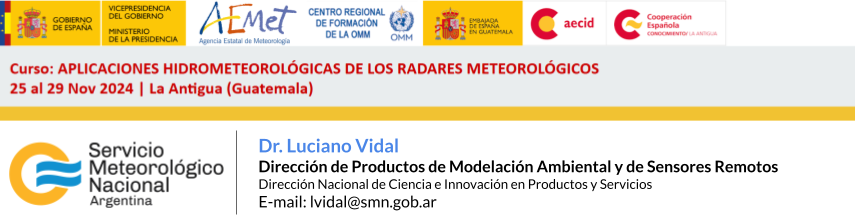

---
# **Práctica N°1:** Explorando datos de radar en diferentes formatos
Los datos de radar meteorologicos puede generarse en diferentes formatos que generalmente dependen en gran medida del fabricante del radar, siempre que hablemos de los daros más crudos del radar. Luego, cuando uno realiza un posprocesamiento de los datos (ej., generar un CAPPI o calcular lluvia), esa salida uno puede elegir en qué formato guardarlo.
En esta pŕactica vamos a explorar 3 formatos de datos:


* NetCDF/CF-Radial
* Gematronik VOL
* EEC HDF5

El **objetivo** entonces es que ustedes puedan familiarizarse con la información que continenen los archivos y poder generar visualizaciones simples de diferentes variables como la reflectividad o el coeficiente de correlación co-polar.

## *¡Comencemos!* 💪
---

# **Instalación de librerías**
Si bien la herramienta Google Colaboratory trae un gran número de librerías preinstaladas, otras más específicas para el manejo de datos radar como [Py-ART](https://arm-doe.github.io/pyart/) no lo estan, y entonces tenemos que instalarlas. También algunas otras librerías que serán muy útiles al momento de graficar y querer agregar mapas y jugar con proyecciones como [Cartopy](https://scitools.org.uk/cartopy/docs/latest/).

In [ ]:

!pip install -qq pyproj
!pip install -qq netCDF4
!pip install -qq arm-pyart
!pip install -qq cartopy
!pip install -qq glob2
!pip install -qq wradlib


# **Descarga de datos**
Vamos a descargar los tres archivos a trabajar y para ello vamos a usar el comando *wget*, que los gaurdará en el disco local de la Google Colab (la nube!).

In [ ]:

# ARCHIVO FORMATO NETCDF/CF-RADIAL
file_nc = 'cfrad.20231029_230952.0000_to_20231029_231540.0000_RMA4_0200_01.nc'
!wget -O file.nc https://www.dropbox.com/scl/fi/7rbt8ed2a7a6w8pp7n1bi/cfrad.20231029_230952.0000_to_20231029_231540.0000_RMA4_0200_01.nc?rlkey=owhb6jltujkun4p0anqvi4ahn&dl=0

# ARCHIVO FORMATO VOL
file_vl = '2019100123200700dBZ.vol'
!wget -O file.vol https://www.dropbox.com/scl/fi/x2688yvcqcomi4h6rzeql/2019100123200700dBZ.vol?rlkey=draui6kazfslfuj6mcqtffcts&dl=0

# ARCHIVO FORMATO HDF5
file_h5 = 'SRM-PPIVol-20220329-195858-03b6.hdf'
!wget -O file.hdf https://www.dropbox.com/scl/fi/9patrgn4tj4sakklsbjpb/SRM-PPIVol-20220329-195858-03b6.hdf?rlkey=m0wej403qu848g5p2ljqoj4rv&dl=0


# **Importamos las librerías**

In [ ]:

import pyart
import numpy as np
from matplotlib import pyplot as plt


# **Procesando archivo en formato NetCDF/CF-Radial**
Tenemos varias librerias que permiten leer este formato de archivos pero por una cuestión práctica vamos a explorar la librería `pyart` ya que esta pensada para el manejo de datos de radar. Existan otras librerías como por ejemplo `wradlib`, pero no la utilizaremoa por ahora.

### 1. Lectura del archivo

In [4]:
radar = pyart.io.read('file.nc')

### 2. Variables disponibles

In [ ]:
print(radar.fields.keys())

### 3. Acceso a las variables y su contenido

In [ ]:
# Datos del sitio radar
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
radar_alt = radar.altitude['data'][0]

# Veamos que valores son ...
print(radar_lat, radar_lon, radar_alt)

### 4. Elevaciones disponibles (PPI)

In [ ]:
print(radar.fixed_angle['data'].data)

### 5. Accediendo a un dado PPI

In [ ]:

# Definimos la elevacion de interés (PPI)
nelev=0

# Indices de inicio y fin de PPI (necesarios para lo que sigue)
start_index = radar.sweep_start_ray_index['data'][nelev]
end_index   = radar.sweep_end_ray_index['data'][nelev]

# Extraemos las coordenadas LAT/LON de los pixeles del PPI
lats_rad = radar.gate_latitude['data'][start_index:end_index]
lons_rad = radar.gate_longitude['data'][start_index:end_index]

# Extraemos los datos de reflectividad horizontal
ZH = radar.fields['DBZH']['data'][start_index:end_index, :]

# ¿Qué dimensiones tiene ZH?
print('Tamaño de la matriz ZH:')
print(ZH.shape)

# ¿Que aspecto tiene? Hagamos un grafico simple ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 1')
plt.pcolormesh(ZH)
plt.colorbar()
plt.show()

# Podemos mejorar un poco la figura ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 2')
plt.figure(figsize=[8,5])
plt.pcolormesh(ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()

# Mas paletas de colores aqui:
# https://arm-doe.github.io/pyart/examples/plotting/plot_choose_a_colormap.html
# https://matplotlib.org/stable/users/explain/colors/colormaps.html


### 6. Mejorando la visualización del PPI

In [ ]:

# Ahora vamos a utilizar las matrices de latitud y longitud

plt.figure(figsize=[8,6])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


In [ ]:

# Le vamos a sumar un anillo con el alcance máximo asi nos es más fácil
# saber hasta donde esperamos ver datos
rmax=238 # En kilometros

R=12742/2 # Radio medio de la Tierra
mm=2*np.pi*R/360
alfa=np.linspace(-np.pi,np.pi,10000)
lat_rmax = np.array([])
lon_rmax = np.array([])
for line in alfa:
  tmp1 = radar_lat + (rmax/mm)*np.sin(line)
  tmp2 = radar_lon + ((rmax/mm)*np.cos(line)/np.cos(tmp1*np.pi/180))
  lat_rmax = np.append(lat_rmax, tmp1)
  lon_rmax = np.append(lon_rmax, tmp2)

plt.figure(figsize=[8,6.4])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.plot(lon_rmax, lat_rmax, 'k', lw=0.75)
plt.plot(radar_lon, radar_lat, 'ok', ms=5)
plt.xlabel('Longitud Oeste', fontsize=12)
plt.ylabel('Latitud Sur', fontsize=12)
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


# **Procesando archivo en formato VOL**
En este caso utilizaremos nuevamente la librería `pyart`.

### 1. Lectura del archivo

In [22]:
radar = pyart.aux_io.read_rainbow_wrl('file.vol')

### 2. Variables disponibles

In [ ]:
print(radar.fields.keys())

### 3. Acceso a las variables y su contenido

In [ ]:
# Datos del sitio radar
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
radar_alt = radar.altitude['data'][0]

# Veamos que valores son ...
print(radar_lat, radar_lon, radar_alt)

### 4. Elevaciones disponibles (PPI)

In [ ]:
print(np.unique(radar.elevation['data']))

### 5. Accediendo a un dado PPI

In [ ]:

# Definimos la elevacion de interés (PPI)
nelev=0

# Indices de inicio y fin de PPI (necesarios para lo que sigue)
start_index = radar.sweep_start_ray_index['data'][nelev]
end_index   = radar.sweep_end_ray_index['data'][nelev]

# Extraemos las coordenadas LAT/LON de los pixeles del PPI
lats_rad = radar.gate_latitude['data'][start_index:end_index]
lons_rad = radar.gate_longitude['data'][start_index:end_index]

# Extraemos los datos de reflectividad horizontal
ZH = radar.fields['reflectivity']['data'][start_index:end_index, :]

# ¿Qué dimensiones tiene ZH?
print('Tamaño de la matriz ZH:')
print(ZH.shape)

# ¿Que aspecto tiene? Hagamos un grafico simple ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 1')
plt.pcolormesh(ZH)
plt.colorbar()
plt.show()

# Podemos mejorar un poco la figura ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 2')
plt.figure(figsize=[8,5])
plt.pcolormesh(ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()

# Mas paletas de colores aqui:
# https://arm-doe.github.io/pyart/examples/plotting/plot_choose_a_colormap.html
# https://matplotlib.org/stable/users/explain/colors/colormaps.html


### 6. Mejorando la visualización del PPI

In [ ]:

# Ahora vamos a utilizar las coordenadas de latitud y longitud

plt.figure(figsize=[8,6])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


In [ ]:

# Le vamos a sumar un anillo con el alcance máximo asi nos es más fácil
# saber hasta donde esperamos ver datos
rmax=240

R=12742/2 # Radio medio de la Tierra
mm=2*np.pi*R/360
alfa=np.linspace(-np.pi,np.pi,10000)
lat_rmax = np.array([])
lon_rmax = np.array([])
for line in alfa:
  tmp1 = radar_lat + (rmax/mm)*np.sin(line)
  tmp2 = radar_lon + ((rmax/mm)*np.cos(line)/np.cos(tmp1*np.pi/180))
  lat_rmax = np.append(lat_rmax, tmp1)
  lon_rmax = np.append(lon_rmax, tmp2)

plt.figure(figsize=[8,6.4])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.plot(lon_rmax, lat_rmax, 'k', lw=0.75)
plt.plot(radar_lon, radar_lat, 'ok', ms=5)
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


# **Procesando archivo en formato HDF5**

### 1. Lectura del archivo

In [37]:
radar = pyart.aux_io.odim_h5.read_odim_h5('file.hdf')

### 2. Variables disponibles

In [ ]:
for i in radar.fields.keys():
    print(i)

### 3. Acceso a las variables y su contenido

In [ ]:
# Datos del sitio radar
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
radar_alt = radar.altitude['data'][0]

# Veamos que valores son ...
print(radar_lat, radar_lon, radar_alt)

### 4. Elevaciones disponibles (PPI)

In [ ]:
print(np.unique(radar.fixed_angle['data']))

### 5. Accediendo a un dado PPI

In [ ]:

# Definimos la elevacion de interés (PPI)
nelev=0

# Indices de inicio y fin de PPI (necesarios para lo que sigue)
start_index = radar.sweep_start_ray_index['data'][nelev]
end_index   = radar.sweep_end_ray_index['data'][nelev]

# Extraemos las coordenadas LAT/LON de los pixeles del PPI
lats_rad = radar.gate_latitude['data'][start_index:end_index]
lons_rad = radar.gate_longitude['data'][start_index:end_index]

# Extraemos los datos de reflectividad horizontal
ZH = radar.fields['reflectivity_horizontal']['data'][start_index:end_index, :]

# ¿Qué dimensiones tiene ZH?
print('Tamaño de la matriz ZH:')
print(ZH.shape)

# ¿Que aspecto tiene? Hagamos un grafico simple ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 1')
plt.pcolormesh(ZH)
plt.colorbar()
plt.show()

# Podemos mejorar un poco la figura ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 2')
plt.figure(figsize=[8,5])
plt.pcolormesh(ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()

# Mas paletas de colores aqui:
# https://arm-doe.github.io/pyart/examples/plotting/plot_choose_a_colormap.html
# https://matplotlib.org/stable/users/explain/colors/colormaps.html


### 6. Mejorando la visualización del PPI

In [ ]:

# Ahora vamos a utilizar las coordenadas de latitud y longitud

plt.figure(figsize=[8,6])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


In [ ]:

# Le vamos a sumar un anillo con el alcance máximo asi nos es más fácil
# saber hasta donde esperamos ver datos
rmax = [len(ZH.data[0,:])-np.isnan(ZH.data[0,:]).sum()][0]*radar.range['meters_between_gates']/1000

R=12742/2 # Radio medio de la Tierra
mm=2*np.pi*R/360
alfa=np.linspace(-np.pi,np.pi,10000)
lat_rmax = np.array([])
lon_rmax = np.array([])
for line in alfa:
  tmp1 = radar_lat + (rmax/mm)*np.sin(line)
  tmp2 = radar_lon + ((rmax/mm)*np.cos(line)/np.cos(tmp1*np.pi/180))
  lat_rmax = np.append(lat_rmax, tmp1)
  lon_rmax = np.append(lon_rmax, tmp2)

plt.figure(figsize=[8,6.2])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.plot(lon_rmax, lat_rmax, 'k', lw=0.75)
plt.plot(radar_lon, radar_lat, 'ok', ms=5)
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


### 7. ¿Y le agregamos un mapa y otras cositas?

In [ ]:

import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

costas = cartopy.feature.NaturalEarthFeature(
                                             category='physical',
                                             name='coastline',
                                             scale='10m',
                                             facecolor='none'
                                            )

paises = cartopy.feature.NaturalEarthFeature(
                                             category='cultural',
                                             name='admin_0_countries',
                                             scale='10m',
                                             facecolor='none'
                                            )

prov   = cartopy.feature.NaturalEarthFeature(
                                             category='cultural',
                                             name='admin_1_states_provinces_lines',
                                             scale='10m',
                                             facecolor='none'
                                            )

rmax=250.0
R=12742/2 # Radio medio de la Tierra
mm=2*np.pi*R/360
alfa=np.linspace(-np.pi,np.pi,10000)
lat_rmax = np.array([])
lon_rmax = np.array([])
for line in alfa:
  tmp1 = radar_lat + (rmax/mm)*np.sin(line)
  tmp2 = radar_lon + ((rmax/mm)*np.cos(line)/np.cos(tmp1*np.pi/180))
  lat_rmax = np.append(lat_rmax, tmp1)
  lon_rmax = np.append(lon_rmax, tmp2)

fig, ax = plt.subplots(1, 1, figsize=(8,7), subplot_kw={'projection': ccrs.PlateCarree()}, squeeze=False)
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.0001, hspace=0.0001)

im=ax[0][0].pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar(im, ax=ax[0][0], aspect=40, pad=0.01, shrink=0.65)

# Agregamos mapa limites politicos
ax[0][0].add_feature(prov, facecolor='None', edgecolor='gray', linewidth=1.0)
ax[0][0].add_feature(paises, facecolor='None', edgecolor='k', linewidth=1.5)

# Grafico el limite exterior de los datos de radar (rmax)
ax[0][0].plot(lon_rmax, lat_rmax, '--k', lw=1.5)

# Graficamos posición sitio radar
ax[0][0].plot(radar_lon, radar_lat, 'ok', ms=10)

# Titulo de la figura
ax[0][0].set_title(radar.time['units'][14:], fontsize=16, loc='right')
ax[0][0].set_title('ZH PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=16, loc='left')

ax[0][0].set_xlim([lon_rmax.min(), lon_rmax.max()])
ax[0][0].set_ylim([lat_rmax.min(), lat_rmax.max()])

ax[0][0].set_aspect(1.2)

# AGREGAMOS LINES Y MARCAS LAT/LON
gl = ax[0][0].gridlines(
                        crs=ccrs.PlateCarree(),
                        color='gray',
                        linestyle='--',
                        linewidth=0.5,
                        xlocs=np.arange(-180, 180, 1),
                        ylocs=np.arange(-90, 90, 1),
                        draw_labels=True
                       )
gl.top_labels = False
gl.right_labels = False

# Guardamos la figura
plt.savefig('ejemplo.png', transparent=False, bbox_inches='tight')

plt.show()
